In [59]:
# general imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns

# from our documents
import OurFunctions as of

# from Scikit Learn library
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import plot_tree
from sklearn.calibration import CalibratedClassifierCV

# from Imb Learn
from imblearn.over_sampling import SMOTENC, SMOTE



In [60]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic.csv'))
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_preprocessed.csv'))
ASD_diagnosis = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_clinical.csv'))

# CLASSIFICATION

First of all, we split the data into train set and test set, to be sure that our classifier is evaluated on data that it had never seen before.

In [61]:
#ASD_phenotypic = ASD_phenotypic.drop(columns=["SITE_ID", "VIQ_TEST_TYPE", "FIQ_TEST_TYPE", "PIQ_TEST_TYPE"])
ASD_phenotypic = ASD_phenotypic.drop(columns=["SITE_ID"])
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic, ASD_diagnosis['DX_GROUP'], test_size=0.3, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (467, 10)
Test set size: (201, 10)


I want to check the balance between classes for each set, to  be sure we are training the classifier using a good split.

In [62]:
class_counts_test = y_test.value_counts(normalize=True)
class_counts_train = y_train.value_counts(normalize=True)
class_count_train_num = y_train.value_counts()

# Stampa il conteggio delle classi per DX_GROUP
print("Class proportions for:")
print("- test set: " + str(class_counts_test))
print("- train set: " + str(class_counts_train))
print("Num subjects involved per "+ str(class_count_train_num))

Class proportions for:
- test set: DX_GROUP
1    0.60199
2    0.39801
Name: proportion, dtype: float64
- train set: DX_GROUP
1    0.603854
2    0.396146
Name: proportion, dtype: float64
Num subjects involved per DX_GROUP
1    282
2    185
Name: count, dtype: int64


# General pipeline

To achieve a more reliable accuracy score we use k-fold cross validation. In this way we are performing the training on different train and validation fold and we avoid to have a better accuracy based only on the subjects we selected.

In [63]:
def general_pipeline(dataset, target, classifier, encoder = True, scaler = True, parameters_grid_search = None, cv = None, feature_selector=False):

    # Definizione delle metriche da utilizzare come scoring
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Preprocess to make on the train data may include
    # - normalization of the numerical columns
    # - one hot encoding on the categorical columns
    
    categorical_columns = dataset.select_dtypes(include=['object']).columns

    if not encoder:
        transformers = [('num', RobustScaler(), ~dataset.columns.isin(categorical_columns))]
    elif not scaler:
        transformers = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
    elif not encoder and not scaler:
        transformers = []
    else:
        transformers=[
            ('num', RobustScaler(), ~dataset.columns.isin(categorical_columns)),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ]

    preprocessor = ColumnTransformer(transformers=transformers)

    if isinstance(classifier, KNeighborsClassifier):
        parameter_type = 'classifier__n_neighbors'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [3, 5, 7, 9, 11]}  # Valori di n_neighbors da esplorare

        #feature_selector_type = SFS(classifier)
        #selector_parameter = 'feature_selection__n_features_to_select'
        #per default is forward, but if you need to change --> parameters.update({'sfs__direction': ['forward']})
        feature_selector_type = SelectKBest(score_func=f_classif)
        selector_parameter = 'feature_selection__k'
        

    if isinstance(classifier, RandomForestClassifier):
        parameter_type = 'classifier__n_estimators'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [10, 50, 200, 500, 1000]} 

        feature_selector_type = RFE(estimator=classifier)
        selector_parameter = 'feature_selection__n_features_to_select'

    if isinstance(classifier, CalibratedClassifierCV):
        parameter_type = 'classifier__estimator__C'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  
        else:
            parameters = {parameter_type: [1]}  

        #feature_selector_type = SelectFromModel(LinearSVC(penalty='l1', dual=False))
        #selector_parameter = 'feature_selection__max_features'
        feature_selector_type = RFE(estimator=LinearSVC(dual=False))
        selector_parameter = 'feature_selection__n_features_to_select'

    if feature_selector:
        # Initialize RFE with the fitted classifier

        pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selector_type),
        ('classifier', classifier)  
        ])

        parameters.update({selector_parameter: list(range(1, 23+1))})
        
    else:
    # We define the pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier),
            ])

    if cv:
        k_folds = cv
    else:
        k_folds = 5

    # Creazione dell'oggetto GridSearchCV
    grid_search = GridSearchCV(pipeline, parameters, cv= k_folds, scoring=scoring, refit='accuracy')

    # Esecuzione della ricerca a griglia
    grid_search.fit(dataset, target)

    # Visualizzazione dei risultati
    print("Risultati della cross-validation per tutte le combinazioni di iperparametri:")

    means_accuracy = grid_search.cv_results_['mean_test_accuracy']
    stds_accuracy = grid_search.cv_results_['std_test_accuracy']
    means_precision = grid_search.cv_results_['mean_test_precision']
    means_recall = grid_search.cv_results_['mean_test_recall']
    means_f1_score = grid_search.cv_results_['mean_test_f1_score']
    params = grid_search.cv_results_['params']

    for mean_acc, std_acc, mean_prec, mean_rec, mean_f1, params in zip(means_accuracy, stds_accuracy, means_precision, means_recall, means_f1_score, params):
        print(f"Parameters: {params}, Accuracy: {mean_acc:.3f} (±{std_acc:.3f}), Precision: {mean_prec:.3f}, Recall: {mean_rec:.3f}, F1-score: {mean_f1:.3f}")

    best_model = grid_search.best_estimator_
    best_parameter = grid_search.best_params_[parameter_type]
    best_accuracy = grid_search.best_score_
    print("\nBest Parameter founded:")
    print(best_parameter)
    print("Accuracy with theBest Parameter:", best_accuracy)

    if feature_selector:
        # Get the support mask and selected feature names from the preprocessed data
        selected_mask = best_model.named_steps['feature_selection'].get_support()
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        selected_features = feature_names[selected_mask]
        
        print("\nSelected features are:")
        print(f"Number of selected features: {len(selected_features)}")
        print("Selected features:", selected_features)

        non_selected_mask = ~selected_mask
        non_selected_features = feature_names[non_selected_mask]

        print("\nNon selected features are:")
        print(f"Number of non selected features: {len(non_selected_features)}")
        print("Selected features:", non_selected_features)

        return best_model, best_parameter, best_accuracy, selected_features
        
    return best_model, best_parameter, best_accuracy, None
    

In [64]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Stampa la distribuzione delle classi dopo l'applicazione di SMOTE-NC
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())

#sampler = SMOTE(random_state=42) --> in case we want to use only numeric

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Stampa la distribuzione delle classi dopo l'applicazione di SMOTE-NC
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())

DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    282
2    282
Name: count, dtype: int64
DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    282
2    282
Name: count, dtype: int64


# K-NEAREST NEIGHBOOR

In [65]:
classifier = KNeighborsClassifier()
knn_model, knn_parameter, knn_accuracy, _= general_pipeline(X_SMOTE, Y_SMOTE, classifier)


Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_neighbors': 3}, Accuracy: 0.867 (±0.020), Precision: 0.955, Recall: 0.773, F1-score: 0.852
Parameters: {'classifier__n_neighbors': 5}, Accuracy: 0.869 (±0.014), Precision: 0.971, Recall: 0.763, F1-score: 0.853
Parameters: {'classifier__n_neighbors': 7}, Accuracy: 0.858 (±0.025), Precision: 0.964, Recall: 0.745, F1-score: 0.839
Parameters: {'classifier__n_neighbors': 9}, Accuracy: 0.842 (±0.025), Precision: 0.950, Recall: 0.724, F1-score: 0.820
Parameters: {'classifier__n_neighbors': 11}, Accuracy: 0.848 (±0.024), Precision: 0.972, Recall: 0.717, F1-score: 0.824

Best Parameter founded:
5
Accuracy with theBest Parameter: 0.8688211125158029


In [66]:
# Valutazione del modello sui dati di test
y_pred = knn_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.876
Precisione: 0.936
Richiamo: 0.851
F1-score: 0.892


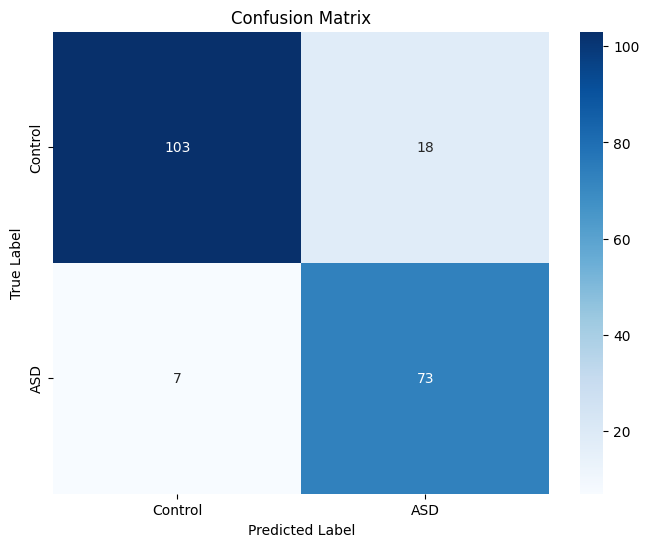

In [67]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Random Forest

To use the Random Forest classifier, I need to have only numerical features, so we will use one-hot-encoding to turn the categorical features (which aren't ordinal) into numerical features. It's not necessary to perform any normalization, but as we want to compare the performance of this classifier with others that use normalization, we will also use normalized data to train this classifier (it's not harmfull for the Random Forest Classifier).

In [68]:
classifier = RandomForestClassifier(random_state=1234)
rf_model, rf_parameter, rf_accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_estimators': 10}, Accuracy: 0.917 (±0.016), Precision: 0.933, Recall: 0.901, F1-score: 0.915
Parameters: {'classifier__n_estimators': 50}, Accuracy: 0.924 (±0.021), Precision: 0.956, Recall: 0.890, F1-score: 0.921
Parameters: {'classifier__n_estimators': 200}, Accuracy: 0.918 (±0.025), Precision: 0.956, Recall: 0.879, F1-score: 0.914
Parameters: {'classifier__n_estimators': 500}, Accuracy: 0.920 (±0.020), Precision: 0.956, Recall: 0.883, F1-score: 0.917
Parameters: {'classifier__n_estimators': 1000}, Accuracy: 0.922 (±0.027), Precision: 0.963, Recall: 0.879, F1-score: 0.918

Best Parameter founded:
50
Accuracy with theBest Parameter: 0.9237831858407081


In [69]:
# Valutazione del modello sui dati di test
y_pred = rf_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.945
Precisione: 0.937
Richiamo: 0.975
F1-score: 0.955


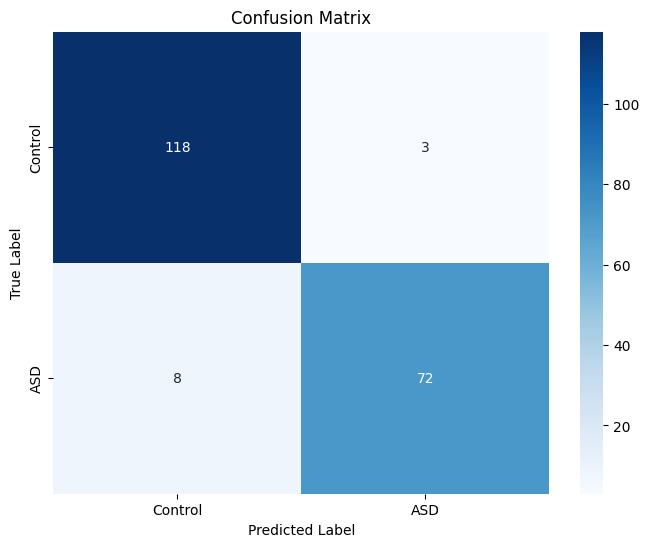

In [70]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Support vector machine

In [71]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False))
svc_model, svc_parameter, svc_accuracy, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__estimator__C': 1}, Accuracy: 0.899 (±0.023), Precision: 0.956, Recall: 0.837, F1-score: 0.892

Best Parameter founded:
1
Accuracy with theBest Parameter: 0.8990044247787612


In [72]:
# Valutazione del modello sui dati di test
y_pred = svc_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.925
Precisione: 0.965
Richiamo: 0.909
F1-score: 0.936


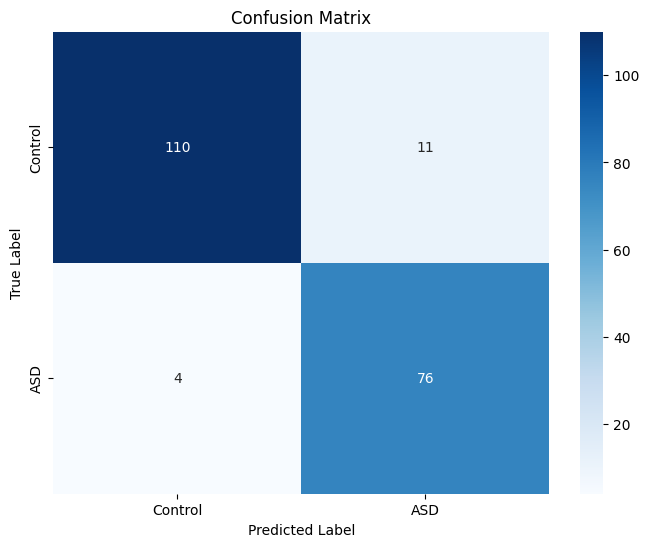

In [73]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Comparison Between Classifiers

In [74]:
# Define a function to evaluate the AUC-ROC for a given model
def evaluate_roc_auc(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_proba)
    return auc_roc

knn_auc_roc = evaluate_roc_auc(knn_model, X_test, y_test)
rf_auc_roc = evaluate_roc_auc(rf_model, X_test, y_test)
svc_auc_roc = evaluate_roc_auc(svc_model, X_test, y_test)

# Print the results
print("K-Nearest Neighbors Classifier AUC-ROC:", knn_auc_roc)
print("Random Forest Classifier AUC-ROC:", rf_auc_roc)
print("Support vector Classifier AUC-ROC:", svc_auc_roc)


K-Nearest Neighbors Classifier AUC-ROC: 0.9376549586776859
Random Forest Classifier AUC-ROC: 0.9829545454545455
Support vector Classifier AUC-ROC: 0.9759297520661157


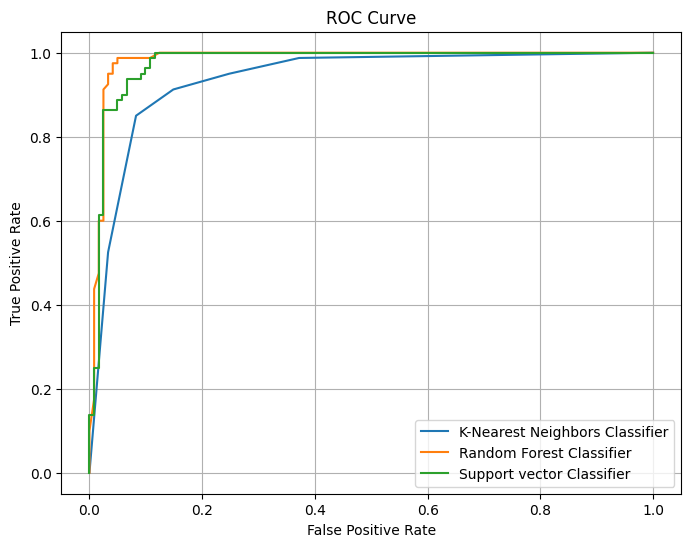

In [75]:
# Define a function to plot the ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

# Plot ROC curve for both models
y_test_binary = (y_test == 2).astype(int)

plt.figure(figsize=(8, 6))
plot_roc_curve(knn_model, X_test, y_test_binary, 'K-Nearest Neighbors Classifier')
plot_roc_curve(rf_model, X_test, y_test_binary, 'Random Forest Classifier')
plot_roc_curve(svc_model, X_test, y_test_binary, 'Support vector Classifier')
plt.show()


# Feature selection

In [76]:
classifier = KNeighborsClassifier()

fs_KNN, fs_KNN_parameter, fs_KNN_accuracy, fs_KNN_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = [9], feature_selector=True)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_neighbors': 9, 'feature_selection__k': 1}, Accuracy: 0.840 (±0.008), Precision: 0.917, Recall: 0.767, F1-score: 0.826
Parameters: {'classifier__n_neighbors': 9, 'feature_selection__k': 2}, Accuracy: 0.897 (±0.014), Precision: 0.977, Recall: 0.816, F1-score: 0.888
Parameters: {'classifier__n_neighbors': 9, 'feature_selection__k': 3}, Accuracy: 0.879 (±0.017), Precision: 0.936, Recall: 0.819, F1-score: 0.871
Parameters: {'classifier__n_neighbors': 9, 'feature_selection__k': 4}, Accuracy: 0.879 (±0.017), Precision: 0.936, Recall: 0.819, F1-score: 0.871
Parameters: {'classifier__n_neighbors': 9, 'feature_selection__k': 5}, Accuracy: 0.887 (±0.015), Precision: 0.946, Recall: 0.826, F1-score: 0.878
Parameters: {'classifier__n_neighbors': 9, 'feature_selection__k': 6}, Accuracy: 0.888 (±0.012), Precision: 0.946, Recall: 0.830, F1-score: 0.881
Parameters: {'classifier__n_neighbors': 9, 'fea

c:\Users\nical\anaconda3\envs\NicaDMML\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2 fits failed out of a total of 115.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nical\anaconda3\envs\NicaDMML\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nical\anaconda3\envs\NicaDMML\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\nical\anaconda3\envs\NicaDMML\Lib\site-packages\sklearn\pipel

In [77]:
# Valutazione del modello sui dati di test
y_pred = fs_KNN.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.915
Precisione: 0.956
Richiamo: 0.901
F1-score: 0.928


In [78]:
classifier = RandomForestClassifier(random_state=1234)

fs_RF, fs_RF_parameter, fs_RF_accuracy, fs_RF_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, parameters_grid_search = [10], feature_selector=True)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 1}, Accuracy: 0.851 (±0.020), Precision: 1.000, Recall: 0.702, F1-score: 0.824
Parameters: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 2}, Accuracy: 0.910 (±0.015), Precision: 0.951, Recall: 0.869, F1-score: 0.905
Parameters: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 3}, Accuracy: 0.892 (±0.019), Precision: 0.904, Recall: 0.879, F1-score: 0.891
Parameters: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 4}, Accuracy: 0.901 (±0.023), Precision: 0.933, Recall: 0.869, F1-score: 0.898
Parameters: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 5}, Accuracy: 0.899 (±0.030), Precision: 0.923, Recall: 0.876, F1-score: 0.897
Parameters: {'classifier__n_estimators': 10, 'feature_selection__n_features_to_select': 

In [79]:
# Valutazione del modello sui dati di test
y_pred = fs_RF.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.930
Precisione: 0.921
Richiamo: 0.967
F1-score: 0.944


In [80]:
classifier = CalibratedClassifierCV(LinearSVC(dual=False))

fs_SVM, fs_SVM_parameter, fs_SVM_accuracy, fs_SVM_selected_features = general_pipeline(X_SMOTE, Y_SMOTE, classifier, feature_selector=True)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 1}, Accuracy: 0.796 (±0.116), Precision: 0.978, Recall: 0.595, F1-score: 0.712
Parameters: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 2}, Accuracy: 0.828 (±0.010), Precision: 0.961, Recall: 0.688, F1-score: 0.799
Parameters: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 3}, Accuracy: 0.833 (±0.014), Precision: 0.967, Recall: 0.692, F1-score: 0.806
Parameters: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 4}, Accuracy: 0.839 (±0.015), Precision: 0.951, Recall: 0.716, F1-score: 0.816
Parameters: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 5}, Accuracy: 0.840 (±0.027), Precision: 0.955, Recall: 0.716, F1-score: 0.817
Parameters: {'classifier__estimator__C': 1, 'feature_selection__n_features_to_select': 6}, Ac

In [81]:
# Valutazione del modello sui dati di test
y_pred = fs_SVM.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")


Valutazione del modello sui dati di test:
Accuratezza: 0.925
Precisione: 0.965
Richiamo: 0.909
F1-score: 0.936


# Outliers detection

In [82]:
ASD_phenotypic.describe()

,AGE_AT_SCAN,SEX,FIQ,VIQ,PIQ,ADI_R_VERBAL_TOTAL_BV,ADOS_TOTAL
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,16.276463,1.118263,107.514649,106.976190,106.287425,11.812874,9.679641
std,7.183633,0.323162,15.333876,15.782631,16.113020,5.027005,3.751550
min,6.470000,1.000000,58.642857,54.888889,37.000000,4.000000,0.000000
25%,11.658575,1.000000,97.000000,97.000000,96.000000,8.000000,7.000000
50%,14.260000,1.000000,107.428571,108.000000,107.000000,9.000000,9.000000
75%,18.495100,1.000000,119.000000,118.000000,118.000000,16.000000,11.000000
max,64.000000,2.000000,148.000000,168.768116,157.000000,26.000000,22.000000


In [83]:
#outlier_subjects.describe()

In [84]:
'''from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
outliers = X_reduced[ASD_phenotypic_outliers['outlier'] == -1]

lof_scores = lof.negative_outlier_factor_

# Plot the data points with color indicating LOF scores
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=-lof_scores, cmap='hot_r', edgecolor='k', label='Inliers')
plt.colorbar(label='LOF Score')
plt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Data points with LOF scores')
plt.show()'''


"from sklearn.decomposition import PCA\nimport matplotlib.pyplot as plt\n\n# Perform PCA for dimensionality reduction\npca = PCA(n_components=2)\nX_reduced = pca.fit_transform(X)\noutliers = X_reduced[ASD_phenotypic_outliers['outlier'] == -1]\n\nlof_scores = lof.negative_outlier_factor_\n\n# Plot the data points with color indicating LOF scores\nplt.figure(figsize=(10, 6))\nplt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=-lof_scores, cmap='hot_r', edgecolor='k', label='Inliers')\nplt.colorbar(label='LOF Score')\nplt.scatter(outliers[:, 0], outliers[:, 1], c='blue', edgecolor='k', marker='x', s=100, label='Outliers')  # Highlight outliers\nplt.xlabel('PCA Component 1')\nplt.ylabel('PCA Component 2')\nplt.title('Data points with LOF scores')\nplt.show()"

Let's see the changes in the data distribution per each feature

In [85]:
'''ASD_phenotypic_without_outliers = ASD_phenotypic[ASD_phenotypic_outliers['outlier'] == 1]
ASD_diagnosis_without_outliers = ASD_diagnosis[ASD_phenotypic_outliers['outlier'] == 1]
of.plot_distributions(ASD_phenotypic_without_outliers)'''

"ASD_phenotypic_without_outliers = ASD_phenotypic[ASD_phenotypic_outliers['outlier'] == 1]\nASD_diagnosis_without_outliers = ASD_diagnosis[ASD_phenotypic_outliers['outlier'] == 1]\nof.plot_distributions(ASD_phenotypic_without_outliers)"

In [86]:
#of.plot_distributions(ASD_phenotypic)

let's see if this make a better training

# Outlier Detection

In [99]:
contamination_factor = [0.001, 0.0015, 0.006, 0.008]

In [101]:
def outlier_detector(dataset, diagnosis, contamination_factor):
    dataset_outliers = dataset.select_dtypes(include=[np.number])
    X = dataset_outliers.values

    # Initialize Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination_factor)  # Adjust parameters as needed
    '''n_neighbors | if too small: model sensible to noise and random outliers
                 if too large: diculties in local outliers detection, in particular if in absence oa a uniform distribution
       contamination | data portion expected as outliers'''
    # Fit the model and predict outliers
    outliers = lof.fit_predict(X)

    # Print number of detected outliers
    print(f"___________________\nNumber of outliers detected: {np.sum(outliers == -1)}")

    # outliers == -1 indicates outliers, 1 indicates inliers
    dataset_outliers['outlier'] = outliers

    outlier_subjects = dataset_outliers[dataset_outliers['outlier'] == -1]

    pd.set_option('display.max_columns', None); outlier_subjects.T

    dataset_without_outliers = dataset[dataset_outliers['outlier'] == 1]
         
    diagnosis_without_outliers = diagnosis[dataset_outliers['outlier'] == 1]

    return dataset_without_outliers, diagnosis_without_outliers

In [102]:
def evaluate_model(X_SMOTE, Y_SMOTE, X_test, y_test, classifier):
    model, _, _, _ = general_pipeline(X_SMOTE, Y_SMOTE, classifier)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [103]:
# Initialize dictionaries to store best accuracy and contamination for each classifier
best_accuracies = {KNeighborsClassifier: 0, RandomForestClassifier: 0, CalibratedClassifierCV: 0}
best_contaminations = {KNeighborsClassifier: None, RandomForestClassifier: None, CalibratedClassifierCV: None}
#best_accuracy = 0
#best_contamination = None

# Initialize a variable to store the best overall accuracy and corresponding classifier
best_overall_accuracy = 0
best_overall_classifier = None
best_overall_contamination = None

for value in contamination_factor:

    ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers = outlier_detector(ASD_phenotypic, ASD_diagnosis,value)

    X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic_without_outliers, ASD_diagnosis_without_outliers['DX_GROUP'], test_size=0.3, random_state=42)

    categorical_columns = X_train.select_dtypes(include=['object']).columns
    categorical_features = categorical_columns.tolist()

    # Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Applica SMOTE-NC per generare nuovi esempi sintetici
    X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)
    sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Applica SMOTE-NC per generare nuovi esempi sintetici
    X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

    classifiers = [KNeighborsClassifier(), RandomForestClassifier(random_state=1234), CalibratedClassifierCV(LinearSVC(dual=False))]
    for classifier in classifiers:
        print(f"\n_____\nEvaluating classifier: {type(classifier).__name__}")
        
        accuracy = evaluate_model(X_SMOTE, Y_SMOTE, X_test, y_test, classifier)
        # Update best accuracy and contamination for the specific classifier
        classifier_type = type(classifier)

        if accuracy > best_accuracies[classifier_type]:
            best_accuracies[classifier_type] = accuracy
            best_contaminations[classifier_type] = value
        
        # Update best overall accuracy and corresponding classifier and contamination
        if accuracy > best_overall_accuracy:
            best_overall_accuracy = accuracy
            best_overall_classifier = classifier_type
            best_overall_contamination = value

# Print the best results for each classifier
for classifier_type in best_accuracies:
    print(f"\nBest contamination factor for {classifier_type.__name__}: {best_contaminations[classifier_type]} with accuracy: {best_accuracies[classifier_type]}")

# Print the best overall result
print(f"\nBest overall contamination factor: {best_overall_contamination} with accuracy: {best_overall_accuracy} for classifier: {best_overall_classifier.__name__}")

___________________
Number of outliers detected: 1

_____
Evaluating classifier: KNeighborsClassifier
Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'classifier__n_neighbors': 3}, Accuracy: 0.869 (±0.021), Precision: 0.946, Recall: 0.785, F1-score: 0.856
Parameters: {'classifier__n_neighbors': 5}, Accuracy: 0.863 (±0.037), Precision: 0.969, Recall: 0.752, F1-score: 0.844
Parameters: {'classifier__n_neighbors': 7}, Accuracy: 0.858 (±0.037), Precision: 0.979, Recall: 0.734, F1-score: 0.835
Parameters: {'classifier__n_neighbors': 9}, Accuracy: 0.858 (±0.037), Precision: 0.987, Recall: 0.727, F1-score: 0.834
Parameters: {'classifier__n_neighbors': 11}, Accuracy: 0.863 (±0.036), Precision: 0.991, Recall: 0.734, F1-score: 0.841

Best Parameter founded:
3
Accuracy with theBest Parameter: 0.8687580437580437

_____
Evaluating classifier: RandomForestClassifier
Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parameters: {'cl